# View Neighbourhood Demographic Data

Understand and add some key metrics for the city of Sao Paulo from the 2022 Census Data.

Decomposition:
- Step 1: read in the data and create a GeoDataFrame with the Census details and the geometry of the neighbourhoods.
- Step 2: Preprocessing: a lot of the data is already cleaned, we just had to clean up some of the non-numeric columns where there was a '.' instead of a blank row.
- Step 3: Group by the neighbourhood and take the neighbourhood level table which we'll use for analysis.
- Step 4: Calculate our Indicies and summarise the results.

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import uuid 
import os
import sidetable as stb
from scipy.stats import skew
pd.set_option('display.max_columns',None)

def box_plot(df, column):
    sns.boxplot(data = df, y=column)
    plt.title(f'Distrubtion of {column}')
    plt.ylabel('Freq')
    plt.show()

# Step 1: Read Data and name columns

In [2]:
df = pd.read_csv(r"C:\Users\adam.PROPDO\Downloads\Agregados_por_setores_demografia_BR\Agregados_por_setores_demografia_BR.csv",
                  dtype={'CD_setor':'str'},sep=';',low_memory=False)

In [3]:
# Rename the codes to column names where applicable
map_col = {
    "V01006": "total_residents","V01007": "male", "V01008": "female","V01009": "male_0_4","V01010": "male_5_9",
    "V01011": "male_10_14","V01012": "male_15_19", "V01013": "male_20_24","V01014": "male_25_29","V01015": "male_30_39",
    "V01016": "male_40_49","V01017": "male_50_59","V01018": "male_60_69","V01019": "male_70_plus","V01020": "female_0_4",
    "V01021": "female_5_9", "V01022": "female_10_14", "V01023": "female_15_19","V01024": "female_20_24","V01025": "female_25_29",
    "V01026": "female_30_39","V01027": "female_40_49","V01028": "female_50_59","V01029": "female_60_69","V01030": "female_70_plus",
    "V01031": "age_0_4","V01032": "age_5_9","V01033": "age_10_14","V01034": "age_15_19","V01035": "age_20_24",
    "V01036": "age_25_29","V01037": "age_30_39","V01038": "age_40_49","V01039": "age_50_59","V01040": "age_60_69", "V01041": "age_70_plus"
}

df.rename(columns=map_col,inplace=True) 
df.columns = df.columns.str.lower()

# Open the neighbourhood files
shapes_df=gpd.read_parquet(r"P:\Data (adam)\Agente Imovel Team Support\New Data\Neighbourhoods for failed cities\IBGE Censo 2022 Bairros\Cleaned FIles\Cidade Sao Paulo\Sao Paulo Censo 2022.parqeut")
shapes_df['cd_setor'] = shapes_df['cd_setor'].str.rstrip('P')
shapes_df['cd_setor'] = shapes_df['cd_setor'].astype('O')

# Turn into a GeoDataFrame after merging the sector geometry
gdf = pd.merge(df, shapes_df, left_on='cd_setor',right_on='cd_setor',how='left')
gdf = gpd.GeoDataFrame(gdf, geometry='geometry',crs='EPSG:4326')
gdf.dropna(subset=['id'],inplace=True)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 25733 entries, 324330 to 351210
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   cd_setor         25733 non-null  object  
 1   total_residents  25733 non-null  object  
 2   male             25733 non-null  object  
 3   female           25733 non-null  object  
 4   male_0_4         25733 non-null  object  
 5   male_5_9         25733 non-null  object  
 6   male_10_14       25733 non-null  object  
 7   male_15_19       25733 non-null  object  
 8   male_20_24       25733 non-null  object  
 9   male_25_29       25733 non-null  object  
 10  male_30_39       25733 non-null  object  
 11  male_40_49       25733 non-null  object  
 12  male_50_59       25733 non-null  object  
 13  male_60_69       25733 non-null  object  
 14  male_70_plus     25733 non-null  object  
 15  female_0_4       25733 non-null  object  
 16  female_5_9       25733 non-null

# Step 2: Preprocessing Data

- Missing Values in the Dataframe
- Duplicate values if there are any
- Formatting numeric values or percentages properly

In [4]:
gdf.stb.missing().head()

,missing,total,percent
cd_setor,0,25733,0.0
age_25_29,0,25733,0.0
female_50_59,0,25733,0.0
female_60_69,0,25733,0.0
female_70_plus,0,25733,0.0


In [5]:
print(gdf.duplicated().sum())

0


In [6]:
print(gdf.duplicated(subset=['cd_setor']).sum())

0


In [7]:
# This column will remove the missing values where there is a '.' in a blank space.
columns_to_convert = [
    "total_residents", "male", "female", 
    "male_0_4", "male_5_9", "male_10_14", "male_15_19", "male_20_24", 
    "male_25_29", "male_30_39", "male_40_49", "male_50_59", "male_60_69", 
    "male_70_plus", "female_0_4", "female_5_9", "female_10_14", "female_15_19", 
    "female_20_24", "female_25_29", "female_30_39", "female_40_49", 
    "female_50_59", "female_60_69", "female_70_plus", "age_0_4", 
    "age_5_9", "age_10_14", "age_15_19", "age_20_24", "age_25_29", 
    "age_30_39", "age_40_49", "age_50_59", "age_60_69", "age_70_plus"
]

# Convert each specified column to numeric
for i in columns_to_convert:
    try:
        gdf[i] = pd.to_numeric(gdf[i], errors='coerce')
        gdf[i] = gdf[i].fillna(0)
        gdf[i] = gdf[i].astype('int')
    except Exception as e:
        print(f"Error converting column {col}: {e}")

In [8]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 25733 entries, 324330 to 351210
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   cd_setor         25733 non-null  object  
 1   total_residents  25733 non-null  int32   
 2   male             25733 non-null  int32   
 3   female           25733 non-null  int32   
 4   male_0_4         25733 non-null  int32   
 5   male_5_9         25733 non-null  int32   
 6   male_10_14       25733 non-null  int32   
 7   male_15_19       25733 non-null  int32   
 8   male_20_24       25733 non-null  int32   
 9   male_25_29       25733 non-null  int32   
 10  male_30_39       25733 non-null  int32   
 11  male_40_49       25733 non-null  int32   
 12  male_50_59       25733 non-null  int32   
 13  male_60_69       25733 non-null  int32   
 14  male_70_plus     25733 non-null  int32   
 15  female_0_4       25733 non-null  int32   
 16  female_5_9       25733 non-null

In [9]:
gdf.columns

Index(['cd_setor', 'total_residents', 'male', 'female', 'male_0_4', 'male_5_9',
       'male_10_14', 'male_15_19', 'male_20_24', 'male_25_29', 'male_30_39',
       'male_40_49', 'male_50_59', 'male_60_69', 'male_70_plus', 'female_0_4',
       'female_5_9', 'female_10_14', 'female_15_19', 'female_20_24',
       'female_25_29', 'female_30_39', 'female_40_49', 'female_50_59',
       'female_60_69', 'female_70_plus', 'age_0_4', 'age_5_9', 'age_10_14',
       'age_15_19', 'age_20_24', 'age_25_29', 'age_30_39', 'age_40_49',
       'age_50_59', 'age_60_69', 'age_70_plus', 'area_km2', 'nm_mun',
       'geometry', 'id', 'neighborhood'],
      dtype='object')

In [10]:
gdf.sample(2)

,cd_setor,total_residents,male,female,male_0_4,male_5_9,male_10_14,male_15_19,male_20_24,male_25_29,male_30_39,male_40_49,male_50_59,male_60_69,male_70_plus,female_0_4,female_5_9,female_10_14,female_15_19,female_20_24,female_25_29,female_30_39,female_40_49,female_50_59,female_60_69,female_70_plus,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_plus,area_km2,nm_mun,geometry,id,neighborhood
330794,355030826000193,207,83,124,6,5,4,5,4,5,12,15,10,7,10,4,9,5,4,8,3,20,16,14,10,31,10,14,9,9,12,8,32,31,24,17,41,0.006882,São Paulo,"MULTIPOLYGON (((-46.64620 -23.54963, -46.64620...",f149f542e935b87017346b4501eaf614,Higienopolis
329357,355030822000379,208,96,112,11,4,9,5,3,6,12,19,10,13,4,8,4,5,3,15,4,22,26,8,10,7,19,8,14,8,18,10,34,45,18,23,11,0.004805,São Paulo,"POLYGON ((-46.64108 -23.67149, -46.64097 -23.6...",2ac7e1da6099d795a8486261790b2f7c,Vila Miriam


# Step 3: Set Bairro Totals

- Group by neighbourhood and sum up all of the values to a neighbourhood level.

- These are the columns we need to calculate to create neighbourhood data (we create like this incase we need to use later.)


In [11]:
agg_dict = {
    'cd_setor': 'nunique',
    'area_km2': 'sum',
    'total_residents': 'sum',
    'male': 'sum',
    'female': 'sum',
    # Male age groups
    'male_0_4': 'sum', 'male_5_9': 'sum', 'male_10_14': 'sum', 
    'male_15_19': 'sum', 'male_20_24': 'sum', 'male_25_29': 'sum', 
    'male_30_39': 'sum', 'male_40_49': 'sum', 'male_50_59': 'sum', 
    'male_60_69': 'sum', 'male_70_plus': 'sum',
    # Female age groups
    'female_0_4': 'sum', 'female_5_9': 'sum', 'female_10_14': 'sum', 
    'female_15_19': 'sum', 'female_20_24': 'sum', 'female_25_29': 'sum', 
    'female_30_39': 'sum', 'female_40_49': 'sum', 'female_50_59': 'sum', 
    'female_60_69': 'sum', 'female_70_plus': 'sum',
    # Combined age groups
    'age_0_4': 'sum', 'age_5_9': 'sum', 'age_10_14': 'sum', 
    'age_15_19': 'sum', 'age_20_24': 'sum', 'age_25_29': 'sum', 
    'age_30_39': 'sum', 'age_40_49': 'sum', 'age_50_59': 'sum', 
    'age_60_69': 'sum', 'age_70_plus': 'sum',
    # Geometry
    'geometry':'first'
}

# Perform the groupby operation
bairro_level = gdf.groupby(['nm_mun', 'id', 'neighborhood']).agg(agg_dict).reset_index()
bairro_level.rename(columns={'cd_setor':'total_census_setors'},inplace=True)

In [12]:
print(type(bairro_level))
bairro_level.sort_values(by='total_residents',ascending=False).head(5)

<class 'pandas.core.frame.DataFrame'>


,nm_mun,id,neighborhood,total_census_setors,area_km2,total_residents,male,female,male_0_4,male_5_9,male_10_14,male_15_19,male_20_24,male_25_29,male_30_39,male_40_49,male_50_59,male_60_69,male_70_plus,female_0_4,female_5_9,female_10_14,female_15_19,female_20_24,female_25_29,female_30_39,female_40_49,female_50_59,female_60_69,female_70_plus,age_0_4,age_5_9,age_10_14,age_15_19,age_20_24,age_25_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_plus,geometry
354,São Paulo,e00676de7d81d858dbcdbfaf74a84001,Cocaia-Borore,597,38.172871,223112,107681,115431,7477,8405,8276,8971,9947,9235,16905,15124,11937,7118,3628,7133,8101,7895,8548,9836,9293,18061,17552,13930,9130,5316,14721,16591,16250,17619,19865,18622,34990,32701,25921,16399,9171,"POLYGON ((-46.64392 -23.75913, -46.64322 -23.7..."
213,São Paulo,85d48ec62a01d5631744cab6735e25fd,Cidade Tiradentres,410,11.642202,192456,90374,102082,6494,7565,7236,7620,8397,7774,14086,12475,9317,6260,2949,6401,7297,7009,7429,8452,7899,15440,15450,12016,9165,5357,12921,14878,14281,15075,16872,15702,29534,27934,21350,15453,8377,"POLYGON ((-46.38415 -23.57817, -46.38406 -23.5..."
53,São Paulo,1de9ea6670d3da1fc735df5ef7697fb9,Americanopolis,321,7.154105,152414,71622,80792,4437,5149,4976,5536,6274,6162,11070,10450,8442,5390,3582,4141,4831,4917,5249,6246,6285,12205,12439,10518,7633,6222,8610,10006,9924,10810,12539,12467,23275,22889,18967,13045,9856,"MULTIPOLYGON (((-46.64918 -23.69075, -46.64921..."
5,São Paulo,04762a223c9f90c95ac96628c4381836,Parelheiros,347,54.094412,136027,65911,70116,4562,5161,5187,5424,5890,5463,10077,9336,7359,4540,2502,4497,4875,4989,5297,5736,5394,10740,10498,8549,5578,3597,9123,10079,10230,10786,11678,10909,20855,19871,15933,10178,6226,"POLYGON ((-46.73357 -23.87548, -46.73844 -23.8..."
303,São Paulo,c04bd7144d0cb438a3b7f9040ed9549b,Grajau,324,7.860738,134842,64458,70384,4005,4715,4634,5054,5579,5401,9835,9434,7433,5006,3204,3844,4474,4227,4721,5437,5413,10780,11089,8964,6497,4807,7895,9206,8890,9788,11035,10833,20616,20530,16402,11535,8069,"POLYGON ((-46.69950 -23.77583, -46.69873 -23.7..."


# Step 4: Calculate Indicies:

Here we will calculate some indicies based on the basic demographic data and then we will explore the data to determine where the outliers are and ensure that everything looks correct and realistic. E.g. we don't have more children then adults in an area.

### Gender-Based Indices
1. Gender Ratio
2. Male Percentage
3. Female Percentage

### Age-Based Indices
4. Age Dependency Ratio
5. Child Dependency Ratio
6. Elderly Dependency Ratio

### Other Useful Indices
10. Age Skewness by Gender
11. Youth Bulge Index


### Gender Calculations

In [13]:
bairro_level['gender_ratio'] = np.where(
    bairro_level['female'] != 0, bairro_level['male'] / bairro_level['female'], np.nan)

bairro_level['male_ratio'] = np.where(
    bairro_level['male'] != 0, bairro_level['male'] / bairro_level['total_residents'], np.nan)

bairro_level['female_ratio'] = np.where(
    bairro_level['female'] != 0, bairro_level['female'] / bairro_level['total_residents'], np.nan)

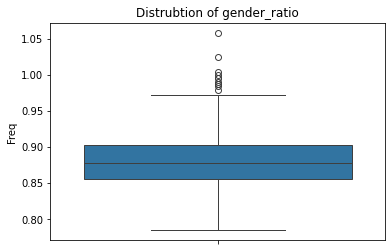

In [14]:
box_plot(bairro_level, 'gender_ratio')

In [15]:
bairro_level[['neighborhood','total_residents','gender_ratio']].sort_values(
    by='gender_ratio',ascending=False).head(10)

,neighborhood,total_residents,gender_ratio
305,Republica,17950,1.058250
175,"Parque Colonial, Grajau",243,1.025000
62,Luz,10432,1.003842
198,Consolacao,29373,0.999387
4,Marsilac,5727,0.996166
178,Centro,32011,0.995947
322,Catumbi,6901,0.990482
355,Bras,51319,0.987337
278,Pari,21568,0.987285
344,Jardim Rizzo,736,0.983827


### Age Dependency

This measures the proportion of dependents (children and elderly) to the working-age population.

In [16]:
dependent_population = (
    bairro_level['male_0_4'] + bairro_level['male_5_9'] + bairro_level['male_10_14'] +
    bairro_level['female_0_4'] + bairro_level['female_5_9'] + bairro_level['female_10_14'] +
    bairro_level['male_70_plus'] + bairro_level['female_70_plus']
)

working_age_population = bairro_level['total_residents'] - dependent_population

bairro_level['age_dependency'] = np.where(
    working_age_population != 0,
    dependent_population / working_age_population,
    np.nan )

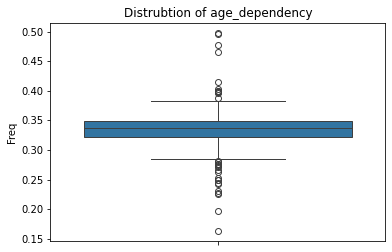

In [17]:
box_plot(bairro_level, 'age_dependency')

In [18]:
bairro_level[['neighborhood','total_residents','age_dependency']].sort_values(
    by='age_dependency',ascending=False).head(10)

,neighborhood,total_residents,age_dependency
48,Jardim Europa,7563,0.497624
75,Vila Ida,2466,0.495452
335,Boacava,1434,0.476828
63,Lapa,8123,0.464923
281,Cidade Vargas,3414,0.415423
20,Alto De Pinheiros,16205,0.402423
291,Jardim Paulistano,3279,0.400085
100,Jardim Marajoara,4351,0.399485
115,Vila Madalena,10755,0.398388
81,Jardim Dos Estados,9268,0.398099


When our age dependency is higher we know that there are more children and older people in the neighbourhood. We can use this as a summarised indicator to understand more about access to social services, we can also understand how the neighbourhood is made up, for instance Alto de Pinheiros and Jardim Europa are mostly likely family-orientated neighbourhoods after the 2022 Census reports.

### Child Dependency

The Child Dependency Ratio (CDR) is a demographic metric that measures the proportion of children (individuals below a certain age, often under 15 years) relative to the working-age population (typically ages 15–64). It helps assess the economic and social support burden placed on the working-age population.

The distributions be,low tell us that the neighbourhood where there are a lot more children compared to adults include Paraisopolis, Vila Santo Henrique and Jardim Capela.

In [19]:
child_dependent = (
    bairro_level['age_0_4'] + bairro_level['age_5_9'] + bairro_level['age_10_14']
)

non_child = bairro_level['total_residents'] - child_dependent

bairro_level['child_dependency'] = np.where(
    child_dependent != 0,
    child_dependent / non_child,
    np.nan )

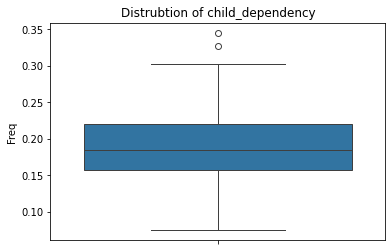

In [20]:
box_plot(bairro_level, 'child_dependency')

In [21]:
bairro_level[['neighborhood','total_residents','child_dependency']].sort_values(
    by='child_dependency',ascending=False).head(10)

,neighborhood,total_residents,child_dependency
260,Vila Santo Henrique,845,0.345541
30,Paraisopolis,55172,0.327143
148,Jardim Capela,107387,0.303319
215,Vila Nova Uniao,19328,0.302865
200,Terceira Divisao,47652,0.302857
44,Parque Taipas,17478,0.302287
153,Jardim Elaine,7305,0.301675
378,"Jacana, Furmas-Parque Estadual",1326,0.301276
399,Jardim Sao Francisco,72965,0.295911
154,Jardim Keralux,9161,0.285033


### Elderly Dependency

In [22]:
old_age = bairro_level['age_70_plus']

rest_of_population = (bairro_level['total_residents'] - old_age - child_dependent)

bairro_level['elderly_dependency'] = np.where(
    old_age != 0,
    old_age / rest_of_population,
    np.nan )

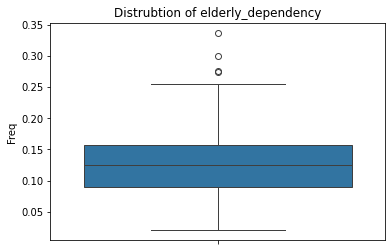

In [23]:
box_plot(bairro_level, 'elderly_dependency')

In [24]:
bairro_level[['neighborhood','total_residents','elderly_dependency']].sort_values(
    by='elderly_dependency',ascending=False).head(10)

,neighborhood,total_residents,elderly_dependency
75,Vila Ida,2466,0.337195
63,Lapa,8123,0.300452
48,Jardim Europa,7563,0.275869
335,Boacava,1434,0.273760
281,Cidade Vargas,3414,0.254153
218,Planalto Paulista,10864,0.248651
115,Vila Madalena,10755,0.239486
129,Paraiso,24487,0.235314
406,Agua Fria,15907,0.234865
81,Jardim Dos Estados,9268,0.234493


## Add Percentage of Population for Elderly & Children

In [25]:
bairro_level['children_pct'] = np.where(child_dependent != 0, child_dependent / bairro_level['total_residents'], np.nan)

In [26]:
bairro_level['elderly_pct'] =  np.where(old_age != 0, old_age / bairro_level['total_residents'], np.nan)

### Age Skewness by Gender

This index measures the asymmetry in the age distribution for males and females separately.

For example, we can see if the males in the neighbourhood are mostly younger or older than the women in the neighbourhood when we observe the distributions.

In São Paulo, both males and females tend to have younger populations in most neighborhoods, with males potentially being slightly younger on average.

#### Male Age Skewness:

- he male population shows a positive skew, indicating that the distribution leans towards younger age groups. The majority of neighborhoods appear to have more younger males than older ones.

#### Female Age Skewness:

- Similarly, the female population also exhibits a positive skew, suggesting that there are more younger females in the neighborhoods than older ones. However, the degree of skewness might be slightly less pronounced compared to males.


In [27]:
bairro_level['male_age_skewness'] = bairro_level[['male_0_4', 'male_5_9', 'male_10_14', 'male_15_19', 'male_20_24', 'male_25_29',
                                  'male_30_39', 'male_40_49', 'male_50_59', 'male_60_69', 'male_70_plus']].apply(skew, axis=1)

bairro_level['female_age_skewness'] = bairro_level[['female_0_4', 'female_5_9', 'female_10_14', 'female_15_19', 'female_20_24', 'female_25_29',
                                    'female_30_39', 'female_40_49', 'female_50_59', 'female_60_69', 'female_70_plus']].apply(skew, axis=1)

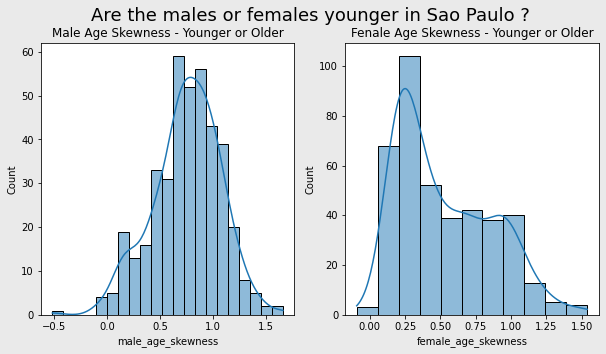

In [28]:
fig, axes = plt.subplots(1,2, figsize=(10,5), facecolor='#eaeaea')

sns.histplot(data=bairro_level, x='male_age_skewness', kde=True, ax=axes[0])
axes[0].set_title('Male Age Skewness - Younger or Older')

sns.histplot(data=bairro_level, x='female_age_skewness', kde=True, ax=axes[1])
axes[1].set_title('Fenale Age Skewness - Younger or Older')

title = 'Are the males or females younger in Sao Paulo ?'
plt.suptitle(title, fontsize='18')

plt.show()

### Youth Bulge Index

The Youth Bulge Index represents the proportion of the population aged 15–24 relative to the total population. A higher Youth Bulge Index indicates a larger concentration of younger individuals in the population, highlighting the "youthfulness" of the neighborhoods.

#### Insights from the Results:
- Distribution Shape: The histogram shows a bell-shaped distribution, meaning most neighborhoods have a Youth Bulge Index clustered around a central value.
- Central Tendency: The peak of the histogram suggests that the majority of neighborhoods have a Youth Bulge Index between approximately 12.5% to 17.5% of the population.
- Spread and Variability: The Youth Bulge Index ranges from around 0.075 to 0.25 across neighborhoods.
- Some neighborhoods have significantly lower or higher proportions of youth, but these are less frequent (as seen in the tails of the distribution).

#### Implications:
- Neighborhoods with higher Youth Bulge Indices are likely to have younger populations, which could have implications for urban planning, education, and employment services.
- Conversely, neighborhoods with lower indices might indicate aging populations or fewer young residents, potentially requiring different public services.

#### Conclusion:
- The Youth Bulge Index highlights that the youth population (ages 15–24) makes up a significant portion of São Paulo's neighborhoods, with most neighborhoods falling within a moderate range of youthfulness. High-index areas may require targeted resources to support younger populations.

In [29]:
# Sum age groups 15-19 and 20-24
bairro_level['youth_population'] = bairro_level['age_15_19'] + bairro_level['age_20_24']

bairro_level['youth_bulge_index'] = np.where(
    bairro_level['youth_population'] != 0,
    bairro_level['youth_population'] / (bairro_level['total_residents'] - bairro_level['youth_population']),
    np.nan )

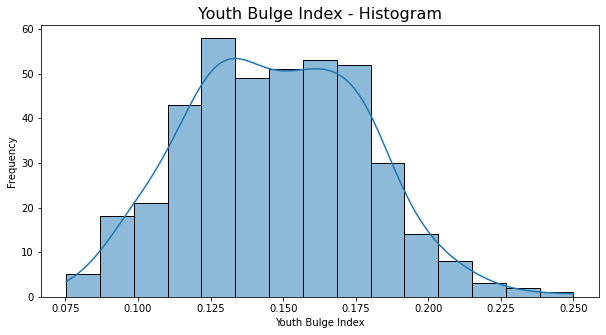

In [30]:
plt.figure(figsize=(10,5))
sns.histplot(data=bairro_level, x='youth_bulge_index', kde=True)
plt.title('Youth Bulge Index - Histogram',fontsize=16)
plt.xlabel('Youth Bulge Index')
plt.ylabel('Frequency')
plt.show()

In [31]:
bairro_level[['neighborhood','total_residents','youth_bulge_index']].sort_values(
    by='youth_bulge_index',ascending=False).head(10)

,neighborhood,total_residents,youth_bulge_index
260,Vila Santo Henrique,845,0.250000
30,Paraisopolis,55172,0.234273
175,"Parque Colonial, Grajau",243,0.227273
215,Vila Nova Uniao,19328,0.218586
357,Ventura Branco,6974,0.217315
154,Jardim Keralux,9161,0.216277
180,Jardim Parana,25976,0.212529
44,Parque Taipas,17478,0.210891
148,Jardim Capela,107387,0.210868
399,Jardim Sao Francisco,72965,0.208430


# Conclusion

In our project we have been able to link the latest census data for the city of Sao Paulo to a shape file that was created recently with the names of the neighbourhoods. After that we calculated the total populations from the demographic table in to make it a neighbourhood level dataset and added some additional indicies which will help us to summarise the data and understand more about the different neighbourhoods across the city of Sao Paulo.